In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import tensorflow as tf

from deepsphere import HealpyGCNN
from deepsphere import healpy_layers as hp_layer
from deepsphere import utils

from tqdm import tqdm

In [2]:
import os

In [3]:
# import pyccl as ccl

# cosmo = ccl.Cosmology(Omega_c = 0.262, Omega_b = 0.048, h = 0.69, sigma8 = 0.83, n_s = 0.96)

# zs=np.linspace(0,1,100)
# dNdz = np.ones(zs.shape)
# bias = 1*np.ones(len(dNdz))

# clustering = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(zs,dNdz), bias=(zs,bias))
# ell = np.arange(0,6144)
# cls_clu = ccl.angular_cl(cosmo, clustering, clustering, ell) #Clustering

In [4]:
# kSZMap = hp.read_map("./kSZ_NS_2048_R_2048_P_2560_DV_256.fits")

In [5]:
# kSZPowSpec = hp.anafast(kSZMap)

In [6]:
kSZFiles = os.listdir('./Data/kSZ')
velFiles = os.listdir('./Data/velocityField')
densFiles = os.listdir('./Data/overdensity')

nside = 64
numSets=len(densFiles)

In [7]:
overdensData = np.zeros((numSets,12*nside**2))
kSZData = np.zeros((numSets,12*nside**2))
velData = np.zeros((numSets,12*nside**2))

In [8]:
for i in range(0,numSets):
    overdensData[i] = hp.reorder(np.load('./Data/overdensity/'+densFiles[i]),r2n=True)
    overdensData[i] = 100*overdensData[i]/np.linalg.norm(overdensData[i])
    kSZData[i] = hp.reorder(np.load('./Data/kSZ/'+kSZFiles[i]),r2n=True)
    kSZData[i] = 100*kSZData[i]/np.linalg.norm(kSZData[i])
    velData[i] = hp.reorder(np.load('./Data/velocityField/'+velFiles[i]),r2n=True)
    velData[i] = 100*velData[i]/np.linalg.norm(velData[i])
# for i in range(0,numSets):
#     overdensData[i] = hp.reorder(hp.synfast(cls_clu,nside=nside),r2n=True)
#     kSZData[i] = hp.reorder(100000*hp.synfast(kSZPowSpec,nside=nside),r2n=True)
#     velData[i] = hp.reorder(kSZData[i]/(overdensData[i]+1),r2n=True)

In [9]:
x_raw = np.stack((overdensData,kSZData),axis=2)
x_raw = np.reshape(x_raw,(numSets,12*nside**2,2))

x_train, x_test = np.split(x_raw, indices_or_sections=[numSets-85])
y_train, y_test = np.split(velData, indices_or_sections=[numSets-85])

In [10]:
dset_test = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_test),
                                 tf.data.Dataset.from_tensor_slices(y_test)))
dset_test = dset_test.shuffle(20)
dset_test = dset_test.batch(10)

dset_train = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train),
                                  tf.data.Dataset.from_tensor_slices(y_train)))
dset_train = dset_train.shuffle(200)
dset_train = dset_train.batch(10)

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

dset_train = dset_train.prefetch(buffer_size=AUTOTUNE)
dset_test = dset_test.prefetch(buffer_size=AUTOTUNE)

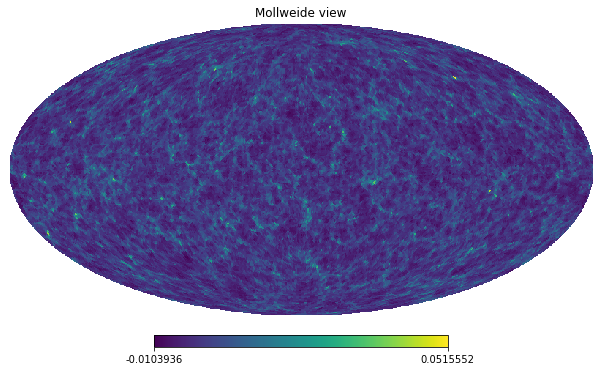

In [12]:
hp.mollview(overdensData[350]/np.linalg.norm(overdensData[350]),nest=True)

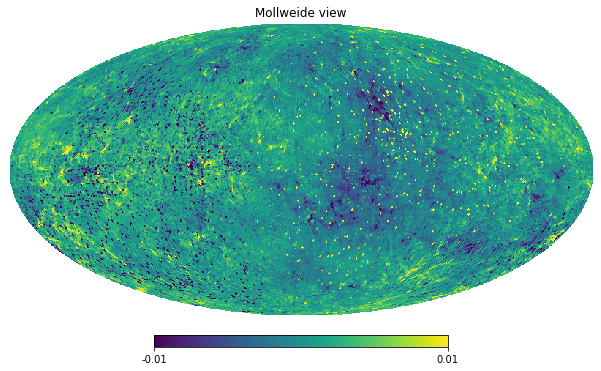

In [13]:
hp.mollview(kSZData[350]/np.linalg.norm(kSZData[350]),nest=True,max=.01,min=-0.01)

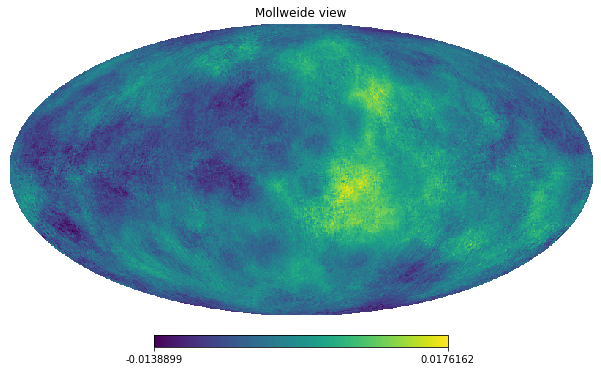

In [14]:
hp.mollview(velData[350]/np.linalg.norm(velData[350]),nest=True)

In [15]:
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [22]:
K = 5
layersBest = [#hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=64, activation="linear"),
                  tf.keras.layers.BatchNormalization(),
                  hp_layer.HealpyChebyshev(K=K, Fout=64, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="linear"),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=16, activation="elu"),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="linear"),
                  hp_layer.HealpyMonomial(K=K, Fout=32, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="linear"),
                  #tf.keras.layers.BatchNormalization(),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  #tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  #hp_layer.HealpyPool(p=1,pool_type='MAX'),
                  hp_layer.HealpyMonomial(K=K, Fout=32, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=32, activation="linear"),
                  #tf.keras.layers.LayerNormalization(axis=1),
                  #hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=16, activation="elu"),
                  #hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=16, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  #tf.keras.layers.Dense(12*nside**2)
                  #hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=24, activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=24, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=24, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=8, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=1, use_bias=True, use_bn=False, 
                                   activation="linear")
         ]

layersTest = [#hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=64, activation="linear"),
                  tf.keras.layers.BatchNormalization(),
                  hp_layer.HealpyChebyshev(K=K, Fout=64, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="linear"),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=16, activation="elu"),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="linear"),
                  hp_layer.HealpyMonomial(K=K, Fout=32, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="linear"),
                  #tf.keras.layers.BatchNormalization(),
#                   hp_layer.HealpyChebyshev(K=K+1, Fout=32, use_bias=True, use_bn=False, 
#                                    activation="linear"),
                  hp_layer.HealpyChebyshev(K=K+1, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  #tf.keras.layers.LayerNormalization(axis=1),
#                   hp_layer.HealpyChebyshev(K=K+1, Fout=32, use_bias=True, use_bn=False, 
#                                            activation="linear"),
                  hp_layer.HealpyMonomial(K=K+1, Fout=32, use_bias=True, use_bn=False, 
                                    activation="linear"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  #hp_layer.HealpyPool(p=1,pool_type='MAX'),
                  hp_layer.HealpyMonomial(K=K+1, Fout=32, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=32, activation="linear"),
                  #tf.keras.layers.LayerNormalization(axis=1),
                  #hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=16, activation="elu"),
                  #hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=16, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  #tf.keras.layers.Dense(12*nside**2)
                  #hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=24, activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=24, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=24, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=8, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=1, use_bias=True, use_bn=False, 
                                   activation="linear")
         ]




In [23]:
#help(hp_layer.HealpyPool)

In [24]:
n_pix = hp.nside2npix(nside)
indices = np.arange(n_pix)
modelHP = HealpyGCNN(nside=nside, layers=layersTest,indices=np.arange(0,12*nside**2), n_neighbors=40)
modelHP.build(input_shape=(None, len(indices), 2))
modelHP.summary(110)

Detected a reduction factor of 1.0, the input with nside 64 will be transformed to 64 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Model: "healpy_gcnn_3"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 batch_normalization_3 (BatchNormalization)      (None, 49152, 2)                            8                
                                                                                                              
 chebyshev_12 (Chebyshev)                        (None, 49152, 64)                           704              
                                                                                                              
 chebyshev_13 (Chebyshev)                        (None, 49152, 32)                           10272            
                       

In [25]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

modelHP.compile(optimizer=opt,
              #loss=tf.keras.losses.Huber(delta=1.0,reduction="auto",name="huber_loss"),
                loss="MSE",
              metrics=[r_square]
)

checkpoint_filepath = './checkpoint'

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath+"/{epoch}",
#     save_weights_only=False,
#     monitor='loss',
#     save_freq=3
# )
filePath = "./models2/Model1_weights.{epoch:02d}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filePath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min')

In [ ]:
initial_epochs = 50
history = modelHP.fit(
    dset_train,
    epochs=initial_epochs,
    validation_data = dset_test,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
140/140 [==============================] - 185s 1s/step - loss: 0.5179 - r_square: -1.5948 - val_loss: 0.1489 - val_r_square: 0.2418
Epoch 2/50
140/140 [==============================] - 183s 1s/step - loss: 0.1201 - r_square: 0.3978 - val_loss: 0.1116 - val_r_square: 0.4425
Epoch 3/50
140/140 [==============================] - 183s 1s/step - loss: 0.1046 - r_square: 0.4767 - val_loss: 0.1040 - val_r_square: 0.4707
Epoch 4/50
140/140 [==============================] - 183s 1s/step - loss: 0.0997 - r_square: 0.5002 - val_loss: 0.1001 - val_r_square: 0.4994
Epoch 5/50
140/140 [==============================] - 183s 1s/step - loss: 0.0970 - r_square: 0.5149 - val_loss: 0.0988 - val_r_square: 0.5139
Epoch 6/50
140/140 [==============================] - 183s 1s/step - loss: 0.0953 - r_square: 0.5252 - val_loss: 0.0965 - val_r_square: 0.5063
Epoch 7/50
140/140 [==============================] - 183s 1s/step - loss: 0.0939 - r_square: 0.5298 - val_loss: 0.0966 - val_r_square: 0.514

In [ ]:
fine_tune_epochs = 2
total_epochs =  initial_epochs + fine_tune_epochs

history_further = modelHP.fit(dset_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=dset_test)

In [ ]:
total_epochs =  initial_epochs + fine_tune_epochs+1

history_furthest = modelHP.fit(dset_train,
                         epochs=total_epochs,
                         initial_epoch=history_further.epoch[-1],
                         validation_data=dset_test)

In [ ]:
total_epochs =  initial_epochs + fine_tune_epochs+1+1

history_furthester = modelHP.fit(dset_train,
                         epochs=total_epochs,
                         initial_epoch=history_furthest.epoch[-1],
                         validation_data=dset_test)

In [ ]:
#modelHP.save('SavedModels/BestModelSoFar/')

In [ ]:
reconst = np.reshape(modelHP(x_train[:1],True).numpy(),(12*nside**2))
goal = np.reshape(y_train[:1],(12*nside**2))

In [ ]:
hp.mollview(goal, nest=True, title="Goal Map");
hp.mollview(reconst, nest=True, title="Reconstruction Map");
hp.mollview(reconst - goal, nest=True, title="Difference");

In [ ]:
reconst = hp.reorder(reconst,n2r=True)
goal = hp.reorder(goal,n2r=True)
plt.loglog(hp.anafast(reconst))
plt.loglog(hp.anafast(goal))
plt.legend(["Reconstructed","Actual"])

In [ ]:
correlation = hp.anafast(reconst,goal)/np.sqrt(hp.anafast(goal)*hp.anafast(reconst)) 

In [ ]:
plt.semilogx(correlation);
plt.grid()
plt.ylim([0, 1]);

In [ ]:
np.mean(correlation)

In [ ]:
plt.semilogy(np.concatenate((history.history['loss'],history_further.history['loss'],history_furthest.history['loss'])), label='loss');
plt.semilogy(np.concatenate((history.history['val_loss'],history_further.history['val_loss'],history_furthest.history['val_loss'])), label = 'val_loss');
plt.xlabel('Epoch')
plt.ylabel('loss')
#plt.ylim([0.5, 1])
plt.legend(loc='upper right');

In [ ]:
plt.semilogy(np.append(np.append(history.history['r_square'],history_further.history['r_square']),history_furthest.history['r_square']), label='r_square')
plt.semilogy(np.append(np.append(history.history['val_r_square'],history_further.history['val_r_square']),history_furthest.history['val_r_square']), label = 'val_r_square')
plt.xlabel('Epoch')
plt.ylabel('loss')
#plt.ylim([0.5, 1])
plt.legend(loc='upper right')